<a href="https://colab.research.google.com/github/josue2510/Data_science_2020_election_support/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install vaderSentiment
!pip install nltk
!pip install gensim

     |████████████████████████████████| 125 kB 29.3 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')
from gensim.models import Word2Vec#libreria para representar palabras en vectores de números
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score#calcula el promedio de los coeficientes de silhouette de todas las muestras
from sklearn.metrics import silhouette_samples#calcula el coeficiente de silhouette de cada muestra
from sklearn.decomposition import PCA#reduce la dimensionalidad a n dimensiones
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter#subclase que cuenta objetos y almacena los elementos en un diccionario
import nltk#kit de herramientas de lenguaje natural
nltk.download('punkt')
from nltk import word_tokenize
from  tqdm import tqdm#libreria que mide el progreso de los loops
from sklearn.model_selection import train_test_split

Mounted at /content/drive
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
tweets = pd.read_csv("/content/drive/MyDrive/tweets.csv", sep=',')
tweets.tweet = tweets.tweet.astype(str)

In [4]:
def get_tokens(text, tokenizer):
    """Tokeniza el texto recibido, remueve dígitos y tokens cortos

    Args:
        text: str

    Returns:
        tokens: array[str]
    """
    tokens = tokenizer(text)
    tokens = ["" if t.isdigit() else t for t in tokens]
    tokens = [t for t in tokens if len(t) > 1]
    return tokens

In [5]:
#separamos cada tweet por palabra y los almacenamos en un vector
#para tener un vector de vectores, tokenizamos los tweets
tweets_words = tweets.tweet.apply(lambda x: get_tokens(x, word_tokenize))

In [6]:
#entrenamos el modelo Word2Vec usando los tweets tokenizados
model = Word2Vec(sentences=tweets_words, workers=1, seed=42)

In [7]:
def flatten(l):
    """ La funcion aplana una lista de listas 
        
        args:
            l (): lista de listas
        return : lista aplanada
    """
    return [item for sublist in l for item in sublist]

In [8]:
#Calculamos la frecuencia de cada palabra
flatten_tweets_words = flatten(tweets_words)
word_freq = nltk.FreqDist(flatten_tweets_words)

In [9]:
def tuple2array(value):
  """ La funcion convierte una tupla a un arrau
        
        args:
            value: tupla
        return : lista: array() 
    """
  lista = []
  for a_tuple in value:
    lista.append(a_tuple[0])
  return lista 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


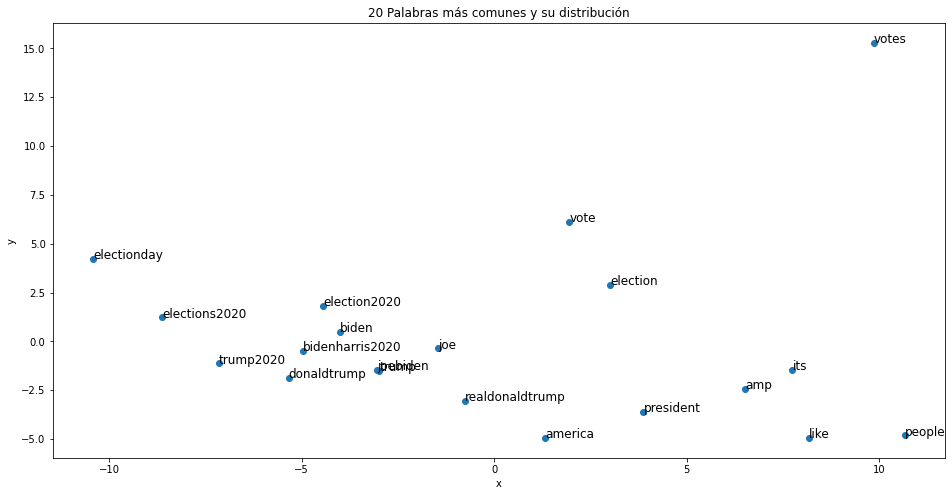

In [10]:
#Elegimos las 18 palabras más frecuentes y obtenemos sus vectores respectivos
common_words = tuple2array(word_freq.most_common(20))
X = model[common_words]
#Transformamos los vectores a 2 dimensiones usando PCA
pca = PCA(n_components=2)
result = pca.fit_transform(X)
#Creamos la representación de las 18 palabras más comunes en 2 dimensiones
plt.figure(figsize=(16,8))
plt.scatter(result[:, 0], result[:, 1])
words = list(common_words)
for i, word in enumerate(words):
  plt.annotate(word, xy=(result[i, 0], result[i, 1]), fontsize=12)
plt.title('20 Palabras más comunes y su distribución')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [11]:
#Función que crea un vector por tweet, promediando los vectores de las palabras que contiene
def vectorize(list_of_docs, model):
    """Genera vectores para la lista de documentos usando Word Embedding

    Args:
        list_of_docs: Lista de documentos
        model: modelo de Gensim Word2Vec entrenado

    Returns:
        features: Lista de documentos vectorizados
    """
    features = []
    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

In [12]:
vectorized_docs = vectorize(tweets_words, model=model)
len(vectorized_docs), len(vectorized_docs[0])

(2144766, 100)

In [13]:
#Agrupamos los diferentes tweets usando KMeans
clustering = KMeans(n_clusters=50).fit(vectorized_docs)

In [14]:
tweets['cluster'] = clustering.labels_
cluster_count = Counter(tweets.cluster)
cluster_count

Counter({0: 69759,
         1: 90537,
         2: 45092,
         3: 78041,
         4: 24430,
         5: 33808,
         6: 118053,
         7: 34499,
         8: 19136,
         9: 52338,
         10: 32718,
         11: 69760,
         12: 36743,
         13: 20460,
         14: 64284,
         15: 69202,
         16: 14700,
         17: 61059,
         18: 7554,
         19: 73030,
         20: 4044,
         21: 30032,
         22: 46000,
         23: 13047,
         24: 20022,
         25: 46439,
         26: 54667,
         27: 17171,
         28: 7830,
         29: 55914,
         30: 18094,
         31: 32830,
         32: 36761,
         33: 24278,
         34: 15040,
         35: 40957,
         36: 59822,
         37: 32793,
         38: 28749,
         39: 27971,
         40: 108862,
         41: 43614,
         42: 63804,
         43: 32249,
         44: 26641,
         45: 19234,
         46: 6592,
         47: 32742,
         48: 53679,
         49: 129685})

In [15]:
#Obtenemos las palabras más representativas en cada cluster
print("Palabras más representativas por cluster(según la cercanía a su centroide):")
for i in range(50):
    tokens_per_cluster = ""
    most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=10)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Palabras más representativas por cluster(según la cercanía a su centroide):
Cluster 0: today and amp especially appears election there actually also definitely 
Cluster 1: amp actually and him especially also them way definitely there 
Cluster 2: actually amp and also clearly basically today shows simply apparently 
Cluster 3: directement alors fortement uniquement donner souriante clairement grce thierrymariani coupable 
Cluster 4: joebiden kamalaharris bidenharris joebidenkamalaharris2020 kamalaharrisvp bidenharris2020 biden joebiden2020 presidentelectjoe 46thpresident 
Cluster 5: election2020 trump elections2020 bidenharris2020 biden bidenharris uselection2020 electionresults election2020results electionday2020 
Cluster 6: actually definitely and think thats way but well there especially 
Cluster 7: disminuyendo porsiteloperdiste clave votacion masivamente ampla favorecen recta explicamos sondeos 
Cluster 8: georgia election2020 pennsylvania nevada ga arizona georgias vote michigan 

In [18]:
#Obtenemos los n tweets más representativos del cluster en específico
test_cluster = 49
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:5]:
    print(tweets['tweet'][d])
    print("-------------")

realdonaldtrump special speech pennsylvania started absurd soundtrack including billy joels piano man theres place id be killing me its come forget life while votebiden realamericansforjoe biden lieslieslies
-------------
shit dont want hear biden tonight 1 deference trump 2 deference maga enthusiasts 3 calling elses deference time focus whats best people office extend olive branch dammit dassit joebiden
-------------
hes gone think need remember realdonaldtrump done henceforth lll referring bowel movements trumps now excuse me im going grunt greasy celebratory trump yourefired bidenharris2020 trump
-------------
id love room trump got cohorts believe lie day 20 incentive people jeopardise careers amp livelihoods shitstain like trump cowardice amp dumbfucks trumpmeltdown trump
-------------
dhaveaclue giannocaldwell joebiden theyre telling resounding yes now its classless donaldtrump scorch earth campaign bullying hunterbiden way horrible people hope hunter beach drinking tequila
-----